In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

dataset_dir = "/content/drive/MyDrive/sneakers-dataset"
print("Exists?", os.path.exists(dataset_dir))
print("Folders inside dataset_dir:", os.listdir(dataset_dir)[:10])


Exists? True
Folders inside dataset_dir: ['converse_chuck_70_high', 'asics_gel-lyte_iii', 'new_balance_574', 'new_balance_327', 'converse_chuck_taylor_all-star_high', 'Men', 'converse_one_star', 'converse_chuck_70_low', 'new_balance_550', 'nike_air_jordan_11']


In [ ]:
DATA_DIR = "/content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset"
# (your path may differ — check with os.listdir)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224,224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATA_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='sparse', subset='training', shuffle=True
)
val_generator = datagen.flow_from_directory(
    DATA_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='sparse', subset='validation', shuffle=True
)


Found 4782 images belonging to 50 classes.
Found 1172 images belonging to 50 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2

def l2_normalize(x):                   # named function — serializable
    return tf.math.l2_normalize(x, axis=1)

def create_embedding_model(input_shape=(224,224,3), embedding_dim=128):
    base = MobileNetV2(input_shape=input_shape, include_top=False, pooling='avg', weights='imagenet')
    base.trainable = False
    inp = layers.Input(shape=input_shape)
    x = base(inp, training=False)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Lambda(l2_normalize, output_shape=(embedding_dim,))(x)
    return Model(inp, x, name="embedding_model")

embedding_model = create_embedding_model()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import numpy as np

def generate_triplets(batch_images, batch_labels):
    anchors, positives, negatives = [], [], []
    labels = np.array(batch_labels)
    n = len(batch_images)
    for i in range(n):
        anchor = batch_images[i]
        a_lbl = labels[i]
        pos_idx = np.random.choice(np.where(labels == a_lbl)[0])
        neg_idx = np.random.choice(np.where(labels != a_lbl)[0])
        anchors.append(anchor)
        positives.append(batch_images[pos_idx])
        negatives.append(batch_images[neg_idx])
    return np.array(anchors), np.array(positives), np.array(negatives)

def triplet_loss(anchor, positive, negative, margin=0.5):
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

@tf.function
def train_step(anchor, positive, negative):
    with tf.GradientTape() as tape:
        a_emb = embedding_model(anchor, training=True)
        p_emb = embedding_model(positive, training=True)
        n_emb = embedding_model(negative, training=True)
        loss = triplet_loss(a_emb, p_emb, n_emb, margin=0.5)
    grads = tape.gradient(loss, embedding_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, embedding_model.trainable_variables))
    return loss

# incremental training (what you actually ran)
EPOCHS = 5
BATCHES_PER_EPOCH = 20   # start small on CPU

for epoch in range(EPOCHS):
    batch_losses = []
    for step in range(BATCHES_PER_EPOCH):
        batch_images, batch_labels = next(train_generator)
        a,p,n = generate_triplets(batch_images, batch_labels)
        loss = train_step(a, p, n)
        batch_losses.append(loss.numpy())
    print(f"Epoch {epoch+1}/{EPOCHS} — Average Loss: {np.mean(batch_losses):.4f}")


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5 — Average Loss: 0.1243
Epoch 2/5 — Average Loss: 0.1212
Epoch 3/5 — Average Loss: 0.1160
Epoch 4/5 — Average Loss: 0.1161
Epoch 5/5 — Average Loss: 0.1234


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

@tf.function
def train_step(anchor, positive, negative):
    with tf.GradientTape() as tape:
        a_emb = embedding_model(anchor, training=True)
        p_emb = embedding_model(positive, training=True)
        n_emb = embedding_model(negative, training=True)
        loss = triplet_loss(a_emb, p_emb, n_emb, margin=0.5)
    grads = tape.gradient(loss, embedding_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, embedding_model.trainable_variables))
    return loss

# incremental training (what you actually ran)
EPOCHS = 5
BATCHES_PER_EPOCH = 50   # start small on CPU

for epoch in range(EPOCHS):
    batch_losses = []
    for step in range(BATCHES_PER_EPOCH):
        batch_images, batch_labels = next(train_generator)
        a,p,n = generate_triplets(batch_images, batch_labels)
        loss = train_step(a, p, n)
        batch_losses.append(loss.numpy())
    print(f"Epoch {epoch+1}/{EPOCHS} — Average Loss: {np.mean(batch_losses):.4f}")


Epoch 1/5 — Average Loss: 0.0859
Epoch 2/5 — Average Loss: 0.0975
Epoch 3/5 — Average Loss: 0.0952
Epoch 4/5 — Average Loss: 0.0897
Epoch 5/5 — Average Loss: 0.0962


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

@tf.function
def train_step(anchor, positive, negative):
    with tf.GradientTape() as tape:
        a_emb = embedding_model(anchor, training=True)
        p_emb = embedding_model(positive, training=True)
        n_emb = embedding_model(negative, training=True)
        loss = triplet_loss(a_emb, p_emb, n_emb, margin=0.5)
    grads = tape.gradient(loss, embedding_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, embedding_model.trainable_variables))
    return loss

# incremental training (what you actually ran)
EPOCHS = 5
BATCHES_PER_EPOCH = 100   # start small on CPU

for epoch in range(EPOCHS):
    batch_losses = []
    for step in range(BATCHES_PER_EPOCH):
        batch_images, batch_labels = next(train_generator)
        a,p,n = generate_triplets(batch_images, batch_labels)
        loss = train_step(a, p, n)
        batch_losses.append(loss.numpy())
    print(f"Epoch {epoch+1}/{EPOCHS} — Average Loss: {np.mean(batch_losses):.4f}")


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5 — Average Loss: 0.0789
Epoch 2/5 — Average Loss: 0.0814
Epoch 3/5 — Average Loss: 0.0822
Epoch 4/5 — Average Loss: 0.0797
Epoch 5/5 — Average Loss: 0.0763


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

@tf.function
def train_step(anchor, positive, negative):
    with tf.GradientTape() as tape:
        a_emb = embedding_model(anchor, training=True)
        p_emb = embedding_model(positive, training=True)
        n_emb = embedding_model(negative, training=True)
        loss = triplet_loss(a_emb, p_emb, n_emb, margin=0.5)
    grads = tape.gradient(loss, embedding_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, embedding_model.trainable_variables))
    return loss

# incremental training (what you actually ran)
EPOCHS = 5
BATCHES_PER_EPOCH = 150   # start small on CPU

for epoch in range(EPOCHS):
    batch_losses = []
    for step in range(BATCHES_PER_EPOCH):
        batch_images, batch_labels = next(train_generator)
        a,p,n = generate_triplets(batch_images, batch_labels)
        loss = train_step(a, p, n)
        batch_losses.append(loss.numpy())
    print(f"Epoch {epoch+1}/{EPOCHS} — Average Loss: {np.mean(batch_losses):.4f}")


Epoch 1/5 — Average Loss: 0.0783
Epoch 2/5 — Average Loss: 0.0739
Epoch 3/5 — Average Loss: 0.0739
Epoch 4/5 — Average Loss: 0.0677
Epoch 5/5 — Average Loss: 0.0759


In [ ]:
# After fixing Lambda to use l2_normalize above:
embedding_model.save("/content/drive/MyDrive/sneaker_model.keras")
# or checkpoint each epoch:
embedding_model.save("/content/drive/MyDrive/checkpoint_epoch1.keras")


In [ ]:
from tensorflow.keras.preprocessing import image
import os, numpy as np
from tqdm import tqdm

embeddings = []
image_paths = []

for folder in os.listdir(DATA_DIR):
    folder_path = os.path.join(DATA_DIR, folder)
    if os.path.isdir(folder_path):
        for fname in os.listdir(folder_path):
            if fname.lower().endswith(('.jpg','.jpeg','.png')):
                p = os.path.join(folder_path, fname)
                img = image.load_img(p, target_size=(224,224))
                arr = image.img_to_array(img)
                arr = np.expand_dims(arr, axis=0)/255.0
                emb = embedding_model.predict(arr, verbose=0)
                embeddings.append(emb[0])
                image_paths.append(p)

embeddings = np.array(embeddings)   # shape (N, 128)
np.savez("/content/drive/MyDrive/sneaker_embeddings.npz", embeddings=embeddings, image_paths=image_paths)


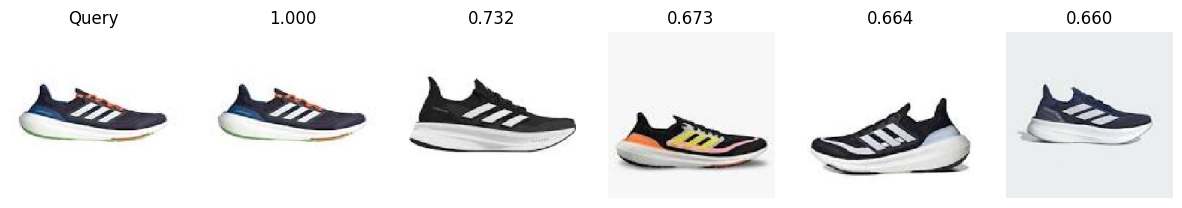

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# load if session was restarted
data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
image_paths = data["image_paths"]

def find_similar(query_path, top_k=5):
    qimg = image.load_img(query_path, target_size=(224,224))
    qarr = image.img_to_array(qimg)
    qarr = np.expand_dims(qarr, axis=0)/255.0
    qemb = embedding_model.predict(qarr, verbose=0)         # shape (1,128)
    sims = cosine_similarity(qemb, embeddings)[0]
    top_idx = sims.argsort()[::-1][:top_k]
    return [(image_paths[i], float(sims[i])) for i in top_idx]

# Display results (matplotlib)
import matplotlib.pyplot as plt
def show_top_matches(query_path, top_k=5):
    matches = find_similar(query_path, top_k=top_k)
    plt.figure(figsize=(15,4))
    plt.subplot(1, top_k+1, 1)
    plt.imshow(image.load_img(query_path, target_size=(224,224)))
    plt.title("Query")
    plt.axis('off')
    for i,(path,score) in enumerate(matches):
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(image.load_img(path, target_size=(224,224)))
        plt.title(f"{score:.3f}")
        plt.axis('off')
    plt.show()

# This is the call that produced the visual output you confirmed:
show_top_matches("/content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/adidas_ultraboost/0004.jpg")


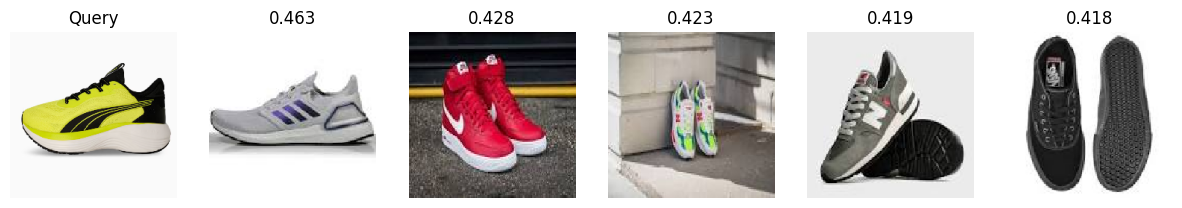

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# load if session was restarted
data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
image_paths = data["image_paths"]

def find_similar(query_path, top_k=5):
    qimg = image.load_img(query_path, target_size=(224,224))
    qarr = image.img_to_array(qimg)
    qarr = np.expand_dims(qarr, axis=0)/255.0
    qemb = embedding_model.predict(qarr, verbose=0)         # shape (1,128)
    sims = cosine_similarity(qemb, embeddings)[0]
    top_idx = sims.argsort()[::-1][:top_k]
    return [(image_paths[i], float(sims[i])) for i in top_idx]

# Display results (matplotlib)
import matplotlib.pyplot as plt
def show_top_matches(query_path, top_k=5):
    matches = find_similar(query_path, top_k=top_k)
    plt.figure(figsize=(15,4))
    plt.subplot(1, top_k+1, 1)
    plt.imshow(image.load_img(query_path, target_size=(224,224)))
    plt.title("Query")
    plt.axis('off')
    for i,(path,score) in enumerate(matches):
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(image.load_img(path, target_size=(224,224)))
        plt.title(f"{score:.3f}")
        plt.axis('off')
    plt.show()

# This is the call that produced the visual output you confirmed:
show_top_matches("/content/drive/MyDrive/adidassamba.png")


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


In [ ]:
data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
image_paths = data["image_paths"]


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# Custom function
def l2_normalize(x):
    return tf.nn.l2_normalize(x, axis=1)

# ✅ Load the full embedding model
embedding_model = load_model(
    "/content/drive/MyDrive/sneaker_model.keras",
    custom_objects={"l2_normalize": l2_normalize}
)

print("✅ Sneaker embedding model loaded successfully")


✅ Sneaker embedding model loaded successfully


In [ ]:
import numpy as np

data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz")
embeddings = data["embeddings"]
labels = data["labels"]
print("✅ Embeddings loaded:", embeddings.shape)


KeyError: 'labels is not a file in the archive'

In [ ]:
import numpy as np

data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz")
print("Files inside npz:", data.files)


Files inside npz: ['embeddings', 'image_paths']


In [ ]:
embeddings = data["embeddings"]
image_paths = data["image_paths"]

print("✅ Loaded:", embeddings.shape, "embeddings")
print("Example path:", image_paths[0])


✅ Loaded: (5953, 128) embeddings
Example path: /content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/yeezy_slide/0008.jpg


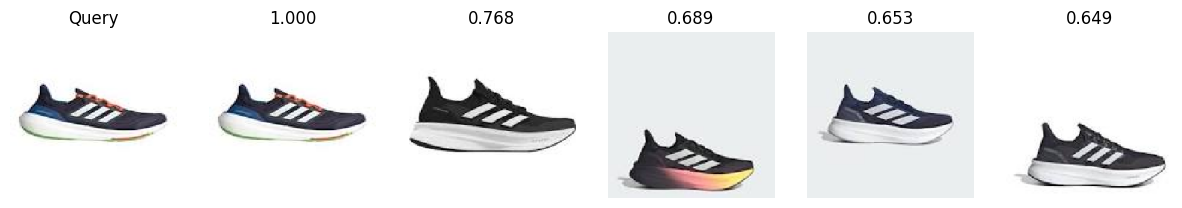

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# load if session was restarted
data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
image_paths = data["image_paths"]

def find_similar(query_path, top_k=5):
    qimg = image.load_img(query_path, target_size=(224,224))
    qarr = image.img_to_array(qimg)
    qarr = np.expand_dims(qarr, axis=0)/255.0
    qemb = embedding_model.predict(qarr, verbose=0)         # shape (1,128)
    sims = cosine_similarity(qemb, embeddings)[0]
    top_idx = sims.argsort()[::-1][:top_k]
    return [(image_paths[i], float(sims[i])) for i in top_idx]

# Display results (matplotlib)
import matplotlib.pyplot as plt
def show_top_matches(query_path, top_k=5):
    matches = find_similar(query_path, top_k=top_k)
    plt.figure(figsize=(15,4))
    plt.subplot(1, top_k+1, 1)
    plt.imshow(image.load_img(query_path, target_size=(224,224)))
    plt.title("Query")
    plt.axis('off')
    for i,(path,score) in enumerate(matches):
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(image.load_img(path, target_size=(224,224)))
        plt.title(f"{score:.3f}")
        plt.axis('off')
    plt.show()

# This is the call that produced the visual output you confirmed:
show_top_matches("/content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/adidas_ultraboost/0004.jpg")


In [ ]:
pip install requests beautifulsoup4 selenium pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.7/512.7 kB 29.9 MB/s eta 0:00:00


In [ ]:
!pip install numpy pandas scikit-learn tensorflow keras requests opencv-python


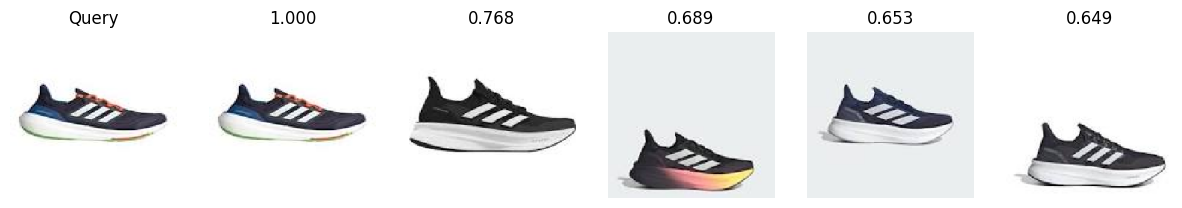

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# load if session was restarted
data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
image_paths = data["image_paths"]

def find_similar(query_path, top_k=5):
    qimg = image.load_img(query_path, target_size=(224,224))
    qarr = image.img_to_array(qimg)
    qarr = np.expand_dims(qarr, axis=0)/255.0
    qemb = embedding_model.predict(qarr, verbose=0)         # shape (1,128)
    sims = cosine_similarity(qemb, embeddings)[0]
    top_idx = sims.argsort()[::-1][:top_k]
    return [(image_paths[i], float(sims[i])) for i in top_idx]

# Display results (matplotlib)
import matplotlib.pyplot as plt
def show_top_matches(query_path, top_k=5):
    matches = find_similar(query_path, top_k=top_k)
    plt.figure(figsize=(15,4))
    plt.subplot(1, top_k+1, 1)
    plt.imshow(image.load_img(query_path, target_size=(224,224)))
    plt.title("Query")
    plt.axis('off')
    for i,(path,score) in enumerate(matches):
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(image.load_img(path, target_size=(224,224)))
        plt.title(f"{score:.3f}")
        plt.axis('off')
    plt.show()

# This is the call that produced the visual output you confirmed:
show_top_matches("/content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/adidas_ultraboost/0004.jpg")


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

def get_image_embedding(img_path):
    """
    Takes an image path and returns a flattened embedding using your trained model.
    """
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    embedding = model.predict(x)  # 'model' should already be loaded (sneaker_model.keras)
    return embedding.flatten()


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

def find_top_k_similar(user_img_path, top_k=5):
    # Generate embedding for user image
    user_embedding = get_image_embedding(user_img_path)
    user_embedding = normalize(user_embedding.reshape(1, -1))

    # Compute similarity with all dataset embeddings
    sims = cosine_similarity(user_embedding, normalized_embeddings)[0]

    # Get top-K indices
    top_indices = sims.argsort()[-top_k:][::-1]  # highest similarity first

    # Return list of (image_path, similarity_score)
    top_images = [image_paths[i] for i in top_indices]
    top_scores = [sims[i] for i in top_indices]

    return list(zip(top_images, top_scores))


In [ ]:
user_image_path = '/content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/converse_chuck_70_low/0004.jpg'

top_k_images = find_top_k_similar(user_image_path, top_k=5)

for img, score in top_k_images:
    print(f"Image: {img}, Similarity Score: {score:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


NameError: name 'normalized_embeddings' is not defined

In [ ]:
import numpy as np
from sklearn.preprocessing import normalize

# Load the embeddings you already have
data = np.load('/content/drive/MyDrive/sneaker_embeddings.npz', allow_pickle=True)
embeddings = data['embeddings']       # shape: (num_images, embedding_dim)
image_paths = data['image_paths']     # paths to dataset images


In [ ]:
normalized_embeddings = normalize(embeddings, axis=1)
print("Embeddings normalized. Shape:", normalized_embeddings.shape)


Embeddings normalized. Shape: (5953, 128)


In [ ]:
user_image_path = '/content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/converse_chuck_70_low/0004.jpg'

top_k_images = find_top_k_similar(user_image_path, top_k=5)

for img, score in top_k_images:
    print(f"Image: {img}, Similarity Score: {score:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Image: /content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/nike_blazer_mid_77/0007.jpg, Similarity Score: 0.3842
Image: /content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/nike_air_max_90/0028.jpg, Similarity Score: 0.3777
Image: /content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/adidas_samba/0063.jpg, Similarity Score: 0.3775
Image: /content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/vans_authentic/0069.jpg, Similarity Score: 0.3691
Image: /content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/yeezy_slide/0081.jpg, Similarity Score: 0.3636


In [ ]:
import pandas as pd

# Example: basic metadata for ScrapingBee
products_df = pd.DataFrame({
    'image_path': image_paths,                        # dataset image paths
    'name': [p.split('/')[-1] for p in image_paths], # you can customize
    'category_id': ['fashion-mens-footwear']*len(image_paths),  # ScrapingBee category
    'merchant_id': ['FK']*len(image_paths),          # ScrapingBee merchant (FK, AMZ, etc.)
    'product_url': ['https://www.flipkart.com']*len(image_paths) # fallback
})


In [ ]:
import requests

SCRAPINGBEE_API_KEY = "L7HY7Y1XIQU180Q88FGOYTA4DWHY627062ONIJJYVLG9CZ6B8DSLCGZ30FGIP8KFG2TW971MRDLCL1QW"  # Replace with your key

def get_price_scrapingbee(category_id, merchant_id, limit=1):
    url = "https://app.scrapingbee.com/api/v1/ecommerce"
    params = {
        "api_key": SCRAPINGBEE_API_KEY,
        "category_id": category_id,
        "merchant_id": merchant_id,
        "limit": limit
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        return None


In [ ]:
import base64

def path_to_base64(path):
    with open(path, "rb") as f:
        img_bytes = f.read()
    encoded = base64.b64encode(img_bytes).decode()
    return f"data:image/jpeg;base64,{encoded}"


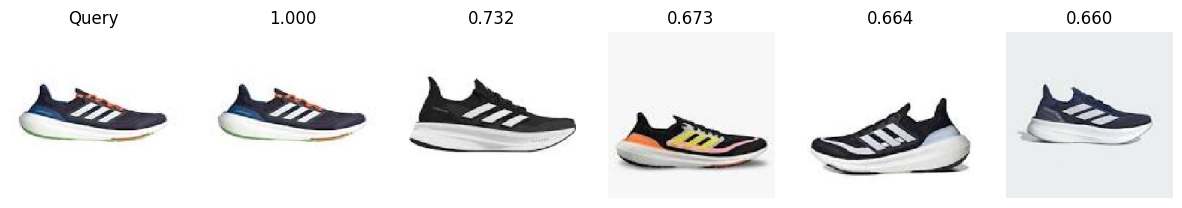

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# load if session was restarted
data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
image_paths = data["image_paths"]

def find_similar(query_path, top_k=5):
    qimg = image.load_img(query_path, target_size=(224,224))
    qarr = image.img_to_array(qimg)
    qarr = np.expand_dims(qarr, axis=0)/255.0
    qemb = embedding_model.predict(qarr, verbose=0)         # shape (1,128)
    sims = cosine_similarity(qemb, embeddings)[0]
    top_idx = sims.argsort()[::-1][:top_k]
    return [(image_paths[i], float(sims[i])) for i in top_idx]

# Display results (matplotlib)
import matplotlib.pyplot as plt
def show_top_matches(query_path, top_k=5):
    matches = find_similar(query_path, top_k=top_k)
    plt.figure(figsize=(15,4))
    plt.subplot(1, top_k+1, 1)
    plt.imshow(image.load_img(query_path, target_size=(224,224)))
    plt.title("Query")
    plt.axis('off')
    for i,(path,score) in enumerate(matches):
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(image.load_img(path, target_size=(224,224)))
        plt.title(f"{score:.3f}")
        plt.axis('off')
    plt.show()

# This is the call that produced the visual output you confirmed:
show_top_matches("/content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/adidas_ultraboost/0004.jpg")


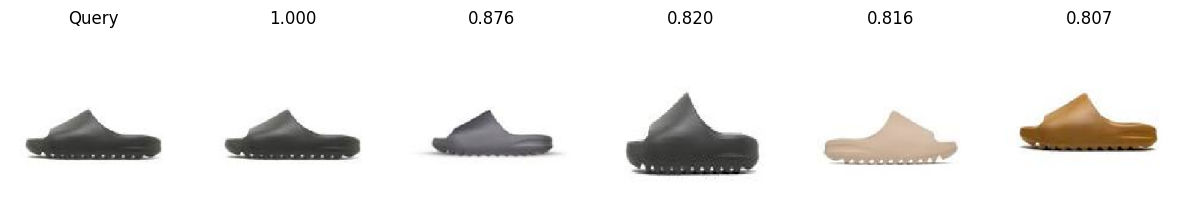

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# load if session was restarted
data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
image_paths = data["image_paths"]

def find_similar(query_path, top_k=5):
    qimg = image.load_img(query_path, target_size=(224,224))
    qarr = image.img_to_array(qimg)
    qarr = np.expand_dims(qarr, axis=0)/255.0
    qemb = embedding_model.predict(qarr, verbose=0)         # shape (1,128)
    sims = cosine_similarity(qemb, embeddings)[0]
    top_idx = sims.argsort()[::-1][:top_k]
    return [(image_paths[i], float(sims[i])) for i in top_idx]

# Display results (matplotlib)
import matplotlib.pyplot as plt
def show_top_matches(query_path, top_k=5):
    matches = find_similar(query_path, top_k=top_k)
    plt.figure(figsize=(15,4))
    plt.subplot(1, top_k+1, 1)
    plt.imshow(image.load_img(query_path, target_size=(224,224)))
    plt.title("Query")
    plt.axis('off')
    for i,(path,score) in enumerate(matches):
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(image.load_img(path, target_size=(224,224)))
        plt.title(f"{score:.3f}")
        plt.axis('off')
    plt.show()

# This is the call that produced the visual output you confirmed:
show_top_matches("/content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/yeezy_slide/0016.jpg")


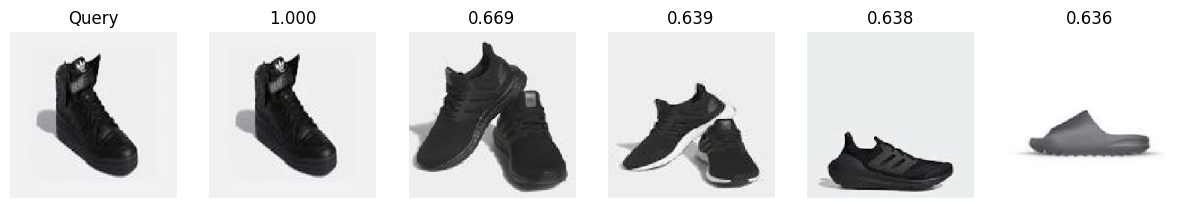

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# load if session was restarted
data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
image_paths = data["image_paths"]

def find_similar(query_path, top_k=5):
    qimg = image.load_img(query_path, target_size=(224,224))
    qarr = image.img_to_array(qimg)
    qarr = np.expand_dims(qarr, axis=0)/255.0
    qemb = embedding_model.predict(qarr, verbose=0)         # shape (1,128)
    sims = cosine_similarity(qemb, embeddings)[0]
    top_idx = sims.argsort()[::-1][:top_k]
    return [(image_paths[i], float(sims[i])) for i in top_idx]

# Display results (matplotlib)
import matplotlib.pyplot as plt
def show_top_matches(query_path, top_k=5):
    matches = find_similar(query_path, top_k=top_k)
    plt.figure(figsize=(15,4))
    plt.subplot(1, top_k+1, 1)
    plt.imshow(image.load_img(query_path, target_size=(224,224)))
    plt.title("Query")
    plt.axis('off')
    for i,(path,score) in enumerate(matches):
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(image.load_img(path, target_size=(224,224)))
        plt.title(f"{score:.3f}")
        plt.axis('off')
    plt.show()

# This is the call that produced the visual output you confirmed:
show_top_matches("/content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/adidas_forum_high/0001.jpg")


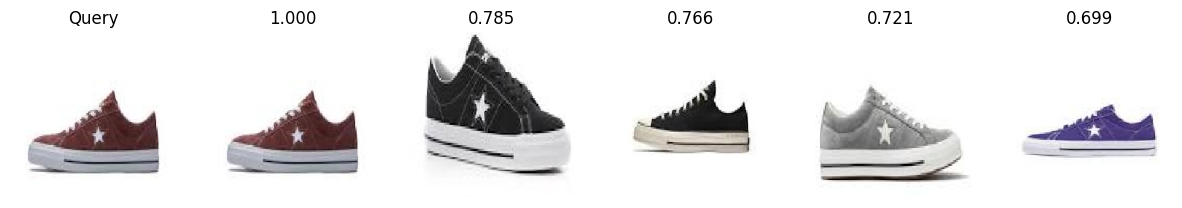

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# load if session was restarted
data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
image_paths = data["image_paths"]

def find_similar(query_path, top_k=5):
    qimg = image.load_img(query_path, target_size=(224,224))
    qarr = image.img_to_array(qimg)
    qarr = np.expand_dims(qarr, axis=0)/255.0
    qemb = embedding_model.predict(qarr, verbose=0)         # shape (1,128)
    sims = cosine_similarity(qemb, embeddings)[0]
    top_idx = sims.argsort()[::-1][:top_k]
    return [(image_paths[i], float(sims[i])) for i in top_idx]

# Display results (matplotlib)
import matplotlib.pyplot as plt
def show_top_matches(query_path, top_k=5):
    matches = find_similar(query_path, top_k=top_k)
    plt.figure(figsize=(15,4))
    plt.subplot(1, top_k+1, 1)
    plt.imshow(image.load_img(query_path, target_size=(224,224)))
    plt.title("Query")
    plt.axis('off')
    for i,(path,score) in enumerate(matches):
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(image.load_img(path, target_size=(224,224)))
        plt.title(f"{score:.3f}")
        plt.axis('off')
    plt.show()

# This is the call that produced the visual output you confirmed:
show_top_matches("/content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/converse_one_star/0001.jpg")


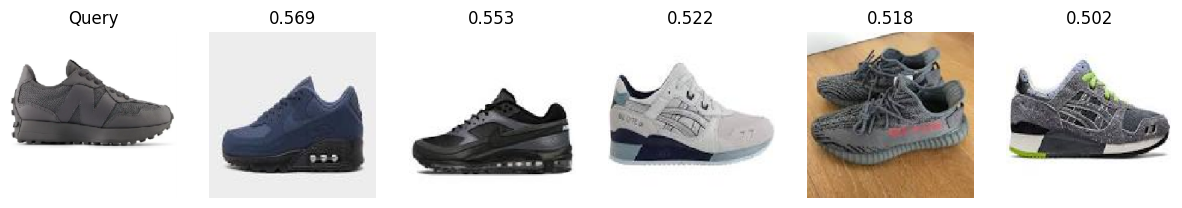

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# load if session was restarted
data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
image_paths = data["image_paths"]

def find_similar(query_path, top_k=5):
    qimg = image.load_img(query_path, target_size=(224,224))
    qarr = image.img_to_array(qimg)
    qarr = np.expand_dims(qarr, axis=0)/255.0
    qemb = embedding_model.predict(qarr, verbose=0)         # shape (1,128)
    sims = cosine_similarity(qemb, embeddings)[0]
    top_idx = sims.argsort()[::-1][:top_k]
    return [(image_paths[i], float(sims[i])) for i in top_idx]

# Display results (matplotlib)
import matplotlib.pyplot as plt
def show_top_matches(query_path, top_k=5):
    matches = find_similar(query_path, top_k=top_k)
    plt.figure(figsize=(15,4))
    plt.subplot(1, top_k+1, 1)
    plt.imshow(image.load_img(query_path, target_size=(224,224)))
    plt.title("Query")
    plt.axis('off')
    for i,(path,score) in enumerate(matches):
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(image.load_img(path, target_size=(224,224)))
        plt.title(f"{score:.3f}")
        plt.axis('off')
    plt.show()

# This is the call that produced the visual output you confirmed:
show_top_matches("/content/drive/MyDrive/shoe1.jpg.png")


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# load if session was restarted
data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
image_paths = data["image_paths"]

def find_similar(query_path, top_k=5):
    qimg = image.load_img(query_path, target_size=(224,224))
    qarr = image.img_to_array(qimg)
    qarr = np.expand_dims(qarr, axis=0)/255.0
    qemb = embedding_model.predict(qarr, verbose=0)         # shape (1,128)
    sims = cosine_similarity(qemb, embeddings)[0]
    top_idx = sims.argsort()[::-1][:top_k]
    return [(image_paths[i], float(sims[i])) for i in top_idx]

# Display results (matplotlib)
import matplotlib.pyplot as plt
def show_top_matches(query_path, top_k=5):
    matches = find_similar(query_path, top_k=top_k)
    plt.figure(figsize=(15,4))
    plt.subplot(1, top_k+1, 1)
    plt.imshow(image.load_img(query_path, target_size=(224,224)))
    plt.title("Query")
    plt.axis('off')
    for i,(path,score) in enumerate(matches):
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(image.load_img(path, target_size=(224,224)))
        plt.title(f"{score:.3f}")
        plt.axis('off')
    plt.show()

# This is the call that produced the visual output you confirmed:
show_top_matches("/content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/adidas_nmd_r1/0005.jpg")


NameError: name 'image' is not defined

In [ ]:
data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
image_paths = data["image_paths"]

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# Custom function
def l2_normalize(x):
    return tf.nn.l2_normalize(x, axis=1)

# ✅ Load the full embedding model
embedding_model = load_model(
    "/content/drive/MyDrive/sneaker_model.keras",
    custom_objects={"l2_normalize": l2_normalize}
)

print("✅ Sneaker embedding model loaded successfully")

✅ Sneaker embedding model loaded successfully


In [ ]:
import numpy as np

data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz")
print("Files inside npz:", data.files)


Files inside npz: ['embeddings', 'image_paths']


In [ ]:
embeddings = data["embeddings"]
image_paths = data["image_paths"]

print("✅ Loaded:", embeddings.shape, "embeddings")
print("Example path:", image_paths[0])


✅ Loaded: (5953, 128) embeddings
Example path: /content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/yeezy_slide/0008.jpg


✅ Loaded: (5954, 128) embeddings


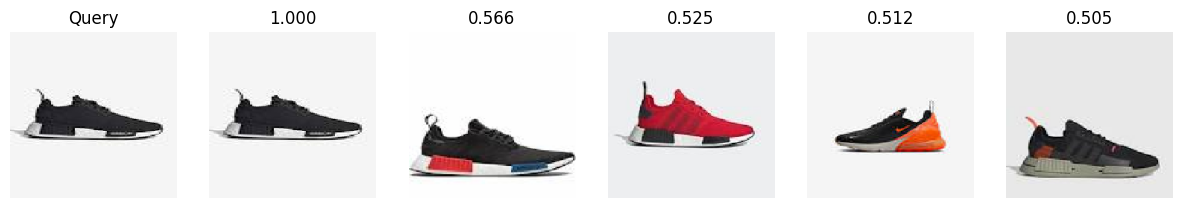

In [ ]:
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# Load embeddings and paths
data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
image_paths = data["image_paths"]

print("✅ Loaded:", embeddings.shape, "embeddings")

# Similarity function
def find_similar(query_path, top_k=5):
    qimg = image.load_img(query_path, target_size=(224,224))
    qarr = image.img_to_array(qimg)
    qarr = np.expand_dims(qarr, axis=0)/255.0
    qemb = embedding_model.predict(qarr, verbose=0)   # (1,128)
    sims = cosine_similarity(qemb, embeddings)[0]
    top_idx = sims.argsort()[::-1][:top_k]
    return [(image_paths[i], float(sims[i])) for i in top_idx]

# Visualization
def show_top_matches(query_path, top_k=5):
    matches = find_similar(query_path, top_k=top_k)
    plt.figure(figsize=(15,4))
    plt.subplot(1, top_k+1, 1)
    plt.imshow(image.load_img(query_path, target_size=(224,224)))
    plt.title("Query")
    plt.axis('off')
    for i,(path,score) in enumerate(matches):
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(image.load_img(path, target_size=(224,224)))
        plt.title(f"{score:.3f}")
        plt.axis('off')
    plt.show()

# Example call
show_top_matches("/content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/adidas_nmd_r1/0005.jpg")


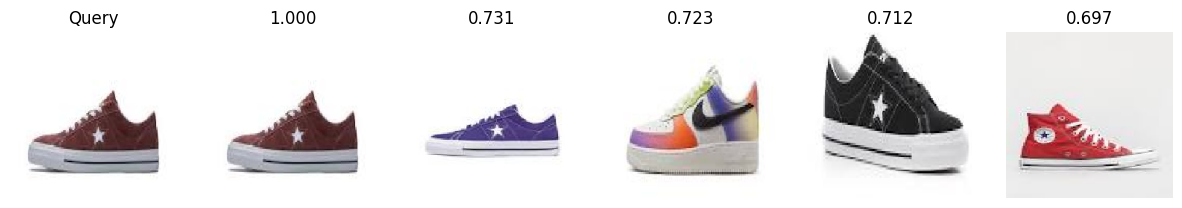

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# load if session was restarted
data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
image_paths = data["image_paths"]

def find_similar(query_path, top_k=5):
    qimg = image.load_img(query_path, target_size=(224,224))
    qarr = image.img_to_array(qimg)
    qarr = np.expand_dims(qarr, axis=0)/255.0
    qemb = embedding_model.predict(qarr, verbose=0)         # shape (1,128)
    sims = cosine_similarity(qemb, embeddings)[0]
    top_idx = sims.argsort()[::-1][:top_k]
    return [(image_paths[i], float(sims[i])) for i in top_idx]

# Display results (matplotlib)
import matplotlib.pyplot as plt
def show_top_matches(query_path, top_k=5):
    matches = find_similar(query_path, top_k=top_k)
    plt.figure(figsize=(15,4))
    plt.subplot(1, top_k+1, 1)
    plt.imshow(image.load_img(query_path, target_size=(224,224)))
    plt.title("Query")
    plt.axis('off')
    for i,(path,score) in enumerate(matches):
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(image.load_img(path, target_size=(224,224)))
        plt.title(f"{score:.3f}")
        plt.axis('off')
    plt.show()

# This is the call that produced the visual output you confirmed:
show_top_matches("/content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/converse_one_star/0001.jpg")



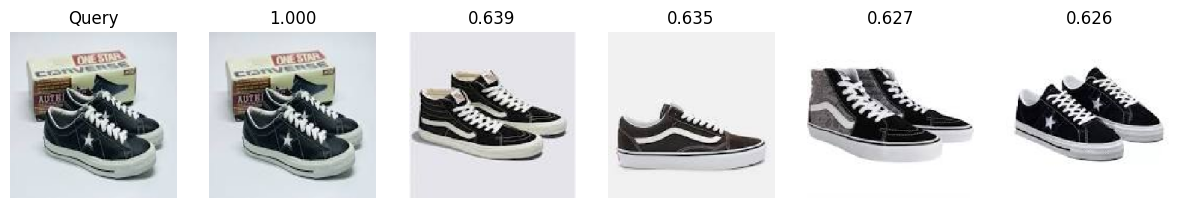

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# load if session was restarted
data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
image_paths = data["image_paths"]

def find_similar(query_path, top_k=5):
    qimg = image.load_img(query_path, target_size=(224,224))
    qarr = image.img_to_array(qimg)
    qarr = np.expand_dims(qarr, axis=0)/255.0
    qemb = embedding_model.predict(qarr, verbose=0)         # shape (1,128)
    sims = cosine_similarity(qemb, embeddings)[0]
    top_idx = sims.argsort()[::-1][:top_k]
    return [(image_paths[i], float(sims[i])) for i in top_idx]

# Display results (matplotlib)
import matplotlib.pyplot as plt
def show_top_matches(query_path, top_k=5):
    matches = find_similar(query_path, top_k=top_k)
    plt.figure(figsize=(15,4))
    plt.subplot(1, top_k+1, 1)
    plt.imshow(image.load_img(query_path, target_size=(224,224)))
    plt.title("Query")
    plt.axis('off')
    for i,(path,score) in enumerate(matches):
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(image.load_img(path, target_size=(224,224)))
        plt.title(f"{score:.3f}")
        plt.axis('off')
    plt.show()

# This is the call that produced the visual output you confirmed:
show_top_matches("/content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/converse_one_star/0055.jpg")


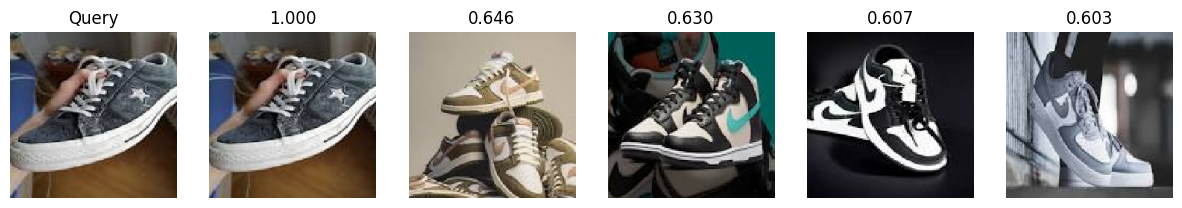

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# load if session was restarted
data = np.load("/content/drive/MyDrive/sneaker_embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
image_paths = data["image_paths"]

def find_similar(query_path, top_k=5):
    qimg = image.load_img(query_path, target_size=(224,224))
    qarr = image.img_to_array(qimg)
    qarr = np.expand_dims(qarr, axis=0)/255.0
    qemb = embedding_model.predict(qarr, verbose=0)         # shape (1,128)
    sims = cosine_similarity(qemb, embeddings)[0]
    top_idx = sims.argsort()[::-1][:top_k]
    return [(image_paths[i], float(sims[i])) for i in top_idx]

# Display results (matplotlib)
import matplotlib.pyplot as plt
def show_top_matches(query_path, top_k=5):
    matches = find_similar(query_path, top_k=top_k)
    plt.figure(figsize=(15,4))
    plt.subplot(1, top_k+1, 1)
    plt.imshow(image.load_img(query_path, target_size=(224,224)))
    plt.title("Query")
    plt.axis('off')
    for i,(path,score) in enumerate(matches):
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(image.load_img(path, target_size=(224,224)))
        plt.title(f"{score:.3f}")
        plt.axis('off')
    plt.show()

# This is the call that produced the visual output you confirmed:
show_top_matches("/content/drive/MyDrive/archive (1)/sneakers-dataset/sneakers-dataset/converse_one_star/0006.jpg")
